
# Project Milestone One: Forming Your Team, Understanding the Problem, and Exploring the Data

#### **Due:** Midnight on October 26th (with 2-hour grace period) — **worth 25 points**

> **Note:** Because we must begin manual grading immediately, there will be *no* late period for this milestone.

This milestone is the first phase of your project. You’ll begin working in teams, select your dataset, perform basic exploratory data analysis (EDA), and frame your classification problem.  

1. **Form your project team.**  
   Convene your team and complete the **Team Contract** (available in your Homework Repository). This is **due on Sunday, October 19th** at midnight (along with Homework 07). Each member must review and sign it before submission.

2. **Select a team leader.**  
   Choose one team member to act as the **Gradescope submitter** for your team. The entire team should collaborate on the notebook, but only the leader will submit.

3. **Explore your dataset and frame your task.**  
   You’ll work through the notebook to  
   - Examine both provided datasets,  
   - Choose one for your project,
   - Be able to describe the classification problem you’ll be solving in business or applied terms,
   - Conduct basic EDA to understand its structure and challenges, and
   - Spot potential challenges, propose solutions, and select appropriate performance metrics.  

This milestone focuses on understanding your data and clearly articulating what your model will eventually predict. You are not required to build a model yet (that will happen in Milestone 2) but of course you have lots of example models to choose from previous Homeworks and Coding Notebooks and you may wish to explore a baseline model as you do this first phase of your project.


### The Datasets

The final project is a **classification task** using **one of two datasets**—one image-based and one text-based. These are the two
domains we have studied in detail, after learning the fundamentals in the first three weeks, and you have all you need to approach either of these datasets with confidence.

#### **1. Food-101 (Images)**  
A web-scraped collection of approximately **101,000 color photos** across **101 food categories** (≈ 800 train / 100 validation / 100 test per class).  
Images vary widely in **lighting, composition, and color balance**, making this dataset excellent for practicing **data cleaning**, **EDA**, and **augmentation** techniques such as random crops, flips, and color jitter.

#### **2. HuffPost News Category (Text)**  
Roughly **200,000 short news items** labeled into **41 topical categories** (e.g., *POLITICS*, *ENTERTAINMENT*, *PARENTING*).  
Each record contains a **headline**, a **short description**, which we will concatenate with a separator token to make a single text string:
> `"headline [SEP] short_description"`.
>
The `[SEP]` token simply marks where the headline ends and the description begins—mirroring conventions used in transformer models such as BERT.


### What To Do


We’ve provided template code to start your project:

* **Download** your selected dataset.
* **Visualize** a few representative samples (images or text excerpts).

After reviewing both datasets, you’ll **choose one** for your semester project.

In the sections that follow:

* **Problem One — Exploratory Data Analysis (EDA):**
  Quantify scale and structure, check class balance, and note any missing/duplicate or inconsistent entries.

* **Problem Two — Challenges & Solution Paths:**
  Identify likely issues (e.g., overlapping categories, imbalanced labels, data-quality problems, length/size variance) and outline practical remedies you would try. *(No model training required.)*

For tips on working with **Hugging Face Datasets** (helpful for large datasets), see the **Appendix**.

> **Important:** Keep only the section for the dataset you select and delete the other before submitting **Milestone 1**.


In [ ]:
# ============================================
# Useful Imports
# ============================================

# --- Standard Libraries
import os
import time
import math
import random
from collections import Counter

# --- Core Data / Numerics
import numpy as np
import pandas as pd

# --- Visualization
import matplotlib.pyplot as plt
# import seaborn as sns              # optional
import matplotlib.ticker as mticker  # optional (for formatted axes)

# --- NLP / Tokenization
import spacy                         # used for text preprocessing (HuffPost)

# --- Progress Tracking
from tqdm import tqdm                # optional (nice for loops)

from IPython.display import display

# --- TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)
from PIL import UnidentifiedImageError

# --- (Optional) Classical ML Baseline Tools
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score


# ============================================
# Global Configuration & Small Utilities
# ============================================

# Reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)   # sets Python, NumPy, and TensorFlow seeds

# Utility: format seconds as HH:MM:SS

"""
Example usage to time your code:

start_time = time.time()
# ... your code here ...
print("Execution Time:", format_hms(time.time() - start_time))
"""

def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


In [ ]:
# If needed (in a new env):
# !pip install -U datasets pillow

In [ ]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 17.3 MB/s eta 0:00:00


In [ ]:
import imagehash

In [ ]:
import imagehash

# --- Hugging Face Datasets
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel

## Prelude: Choose your dataset and take a first look

You’ll pick **one** dataset—either **Food-101 (images)** or **HuffPost (text)**—and run the starter cells to confirm it loads, view class stats, and skim a few samples.

* **Food-101 (images):** 101 classes of web photos with **inconsistent lighting, white balance, color casts, and composition** (plus varying resolutions). These natural quirks make augmentation and input-pipeline choices meaningful.
* **HuffPost (text):** ~200k headline/summary pairs across 41 topics with **class imbalance** and some **category overlap**—good for trying stratified splits and reporting macro-F1 in addition to accuracy.

After you review the two sections below (download → minimal EDA → split), **keep one and delete the other.** Stick with your choice for the entire project.

> **Note:** We use Hugging Face **Dataset/DatasetDict** objects (table-like datasets), not NumPy/Pandas arrays. Most of what you need to know is contained in the template code, but see the **Appendix** for more information on HG Datasets.


---

### Dataset One (Images): Food-101

#### **Load Food-101 as a Dataset**

> Note: this loads a **Hugging Face `Dataset`**, not NumPy or TensorFlow tensors.
> Each sample is stored as a **dictionary** with two keys — `"image"` (a PIL image object) and `"label"` (an integer class ID).
> You can access columns by name, e.g. `food_all["image"]` or `food_all["label"]`, and check the dataset size with `len(food_all)`.
> Unlike arrays, image sizes and aspect ratios may differ across samples — you’ll handle resizing or normalization later during preprocessing.


In [ ]:
food_all = load_dataset("food101", split="train+validation")  # ~101k images total
label_col = "label"

# Sanity check the label column
assert label_col in food_all.features
assert isinstance(food_all.features[label_col], ClassLabel)

food_label_names = food_all.features[label_col].names
print(f"Total images: {len(food_all):,}  |  Classes: {len(food_label_names)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Total images: 101,000  |  Classes: 101


#### **Quick sanity checks (rows, label ids, a few image sizes)**

In [ ]:
# First 5 rows: label id → name
for i in range(5):
    y = food_all[i][label_col]
    print(f"row {i}: id={y}, name={food_label_names[y]}")

labels_list = list(food_all[label_col])
print("labels length:", len(labels_list), "unique classes:", len(set(labels_list)))
print("min/max label IDs:", min(labels_list), max(labels_list))

for i in range(3):
    print(f"image {i} size:", food_all[i]["image"].size)  # (W, H)

row 0: id=6, name=beignets
row 1: id=6, name=beignets
row 2: id=6, name=beignets
row 3: id=6, name=beignets
row 4: id=6, name=beignets
labels length: 101000 unique classes: 101
min/max label IDs: 0 100
image 0 size: (384, 512)
image 1 size: (512, 512)
image 2 size: (512, 383)


#### **Visual preview: random 3×3 grid from TRAIN**

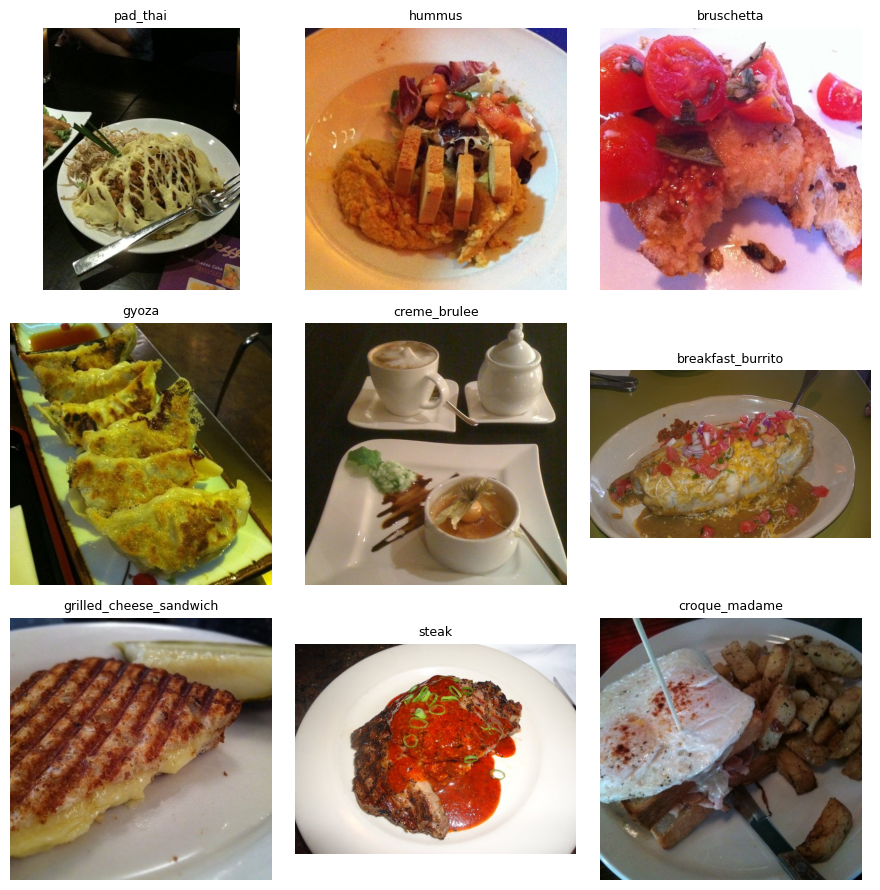

In [ ]:
n, cols, seed = 9, 3, 42
idxs = random.Random(seed).sample(range(len(food_all)), n)
rows = math.ceil(n/cols)

plt.figure(figsize=(3*cols, 3*rows))
for i, idx in enumerate(idxs, 1):
    ex = food_all[idx]
    plt.subplot(rows, cols, i)
    plt.imshow(ex["image"]); plt.axis("off")
    plt.title(food_label_names[ex[label_col]], fontsize=9)
plt.tight_layout(); plt.show()

---

## Problem 1 – Choose the Dataset (10 pts)

#### Objective
In this problem, you will explore the two provided datasets and select one to use for your final project.  
Your goal is to understand the structure, content, and challenges of the dataset through basic exploratory data analysis (EDA).  
By the end of this Milestone notebook, you should be able to explain what makes the dataset interesting, identify potential modeling challenges (e.g., imbalance, ambiguity, quality issues), and justify why it is a good choice for your classification project.


#### What to Do
1. **Load both datasets** and examine the outputs of the template code provided.  
   After this brief inspection, **choose one dataset for your project** and **delete the template code for the other.**  For your chosen dataset, continue with the remaining steps.

2. **Inspect** the dataset's basic properties:  
   - **Number of samples and classes:**  
     Determine how many total examples and distinct categories are present. Verify that the counts match expectations (e.g., 101 food classes or 41 news topics).  
   - **Example records or images:**  
     View several samples to understand the input format, diversity, and potential quality issues.  
     For images, note lighting or composition differences; for text, read a few headlines and summaries to see how expressive they are (done for you in template code).
   - **Distribution of labels (check for imbalance):**  
     Plot or tabulate label frequencies to see whether some classes dominate. Imbalanced datasets can bias model training and may require special handling.  
   - **Missing or inconsistent data:**  
     Look for empty fields, unreadable images, duplicate entries, or mislabeled samples. Handle or document any issues you find.  
   - **Overlapping or ambiguous class labels:**  
     Identify categories that may not be clearly distinct—e.g., “apple pie” vs. “cheesecake,” or “POLITICS” vs. “WORLD NEWS.”  
     Ambiguity in labels can increase confusion between classes and reduce model accuracy.

3. **Visualize key aspects:**  
   Extend the template code to complete the EDA for your chosen dataset:  
   - **Images:**  
     Create visual summaries to better understand the data (some are implemented in the template code).  
     - Verify that the dataset is balanced across classes.  
     - Display a small grid of random images to check variation in appearance, composition, and background (done in template code).  
     - Compare image sizes to determine whether resizing or normalization will be needed.  
     - Examine lighting and color balance—many web-scraped photos vary widely in brightness, saturation, and white balance.  
   - **Text:**  
     Visualize class balance and linguistic properties (some implemented in the template code).  
     - Plot the number of samples per label to confirm class balance or imbalance.  
     - Compute basic text statistics such as average word count or vocabulary size.  
     - Examine examples for duplicates, near-duplicates, or entries that might fit multiple categories.  
     - *(Optional)* Generate a word-frequency plot or word cloud to highlight distinctive terms for a few classes.

4. **Answer the graded questions below.**


Total images: 101,000  |  Classes: 101


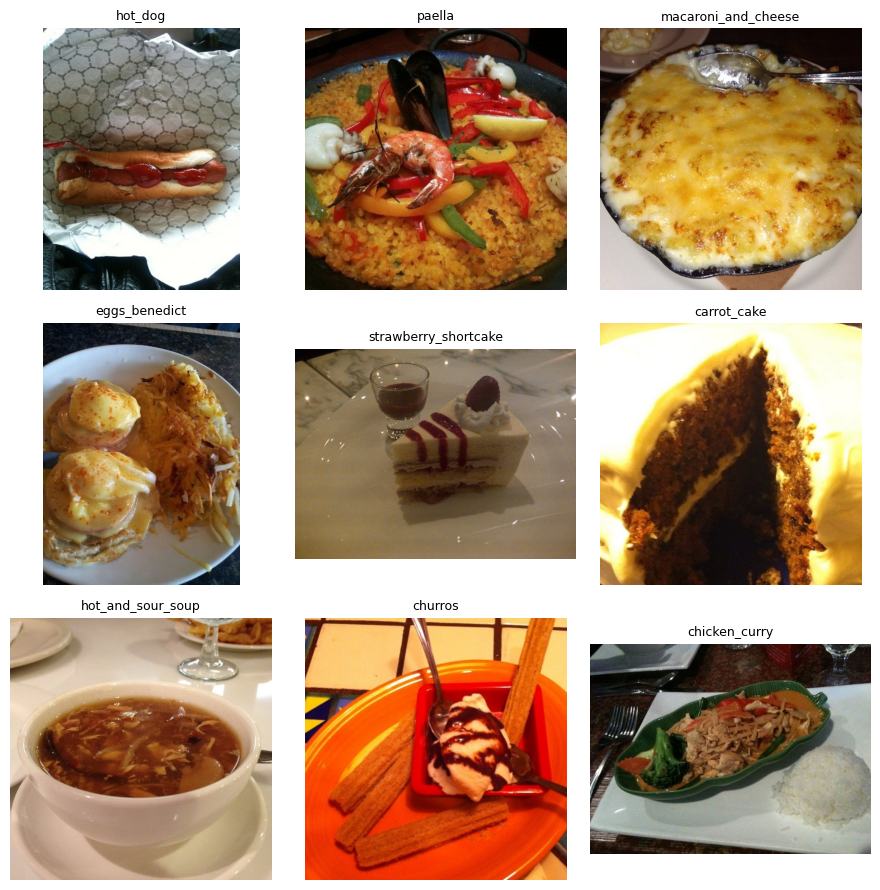

In [ ]:
# Your code here, add as many cells as you like. Provide organization and structure by appropriate comments, labels, and variable names. Explain what
# you are doing in case you come back to this in a year.

# Verifying number of samples and classes
print(f"Total images: {len(food_all):,}  |  Classes: {len(food_label_names)}")

# Looking a few samples of images
n, cols, seed = 9, 3, 1
idxs = random.Random(seed).sample(range(len(food_all)), n)
rows = math.ceil(n/cols)

plt.figure(figsize=(3*cols, 3*rows))
for i, idx in enumerate(idxs, 1):
    ex = food_all[idx]
    plt.subplot(rows, cols, i)
    plt.imshow(ex["image"]); plt.axis("off")
    plt.title(food_label_names[ex[label_col]], fontsize=9)
plt.tight_layout(); plt.show()

In [ ]:
# What stood out to you from your EDA?
# Did you notice any imbalanced or ambiguous classes?
# Any patterns, anomalies, or potential sources of bias?
# For images: note any variation in lighting, composition, or color.




# Overlapping or ambiguous class labels:
# Identify categories that may not be clearly distinct—e.g., “apple pie” vs. “cheesecake,” or “POLITICS” vs. “WORLD NEWS.”
# Ambiguity in labels can increase confusion between classes and reduce model accuracy.


In [ ]:
print("Number of images: ",len(food_all))
print("Number of class labels: ",len(set(food_label_names)))

Number of images:  101000
Number of class labels:  101


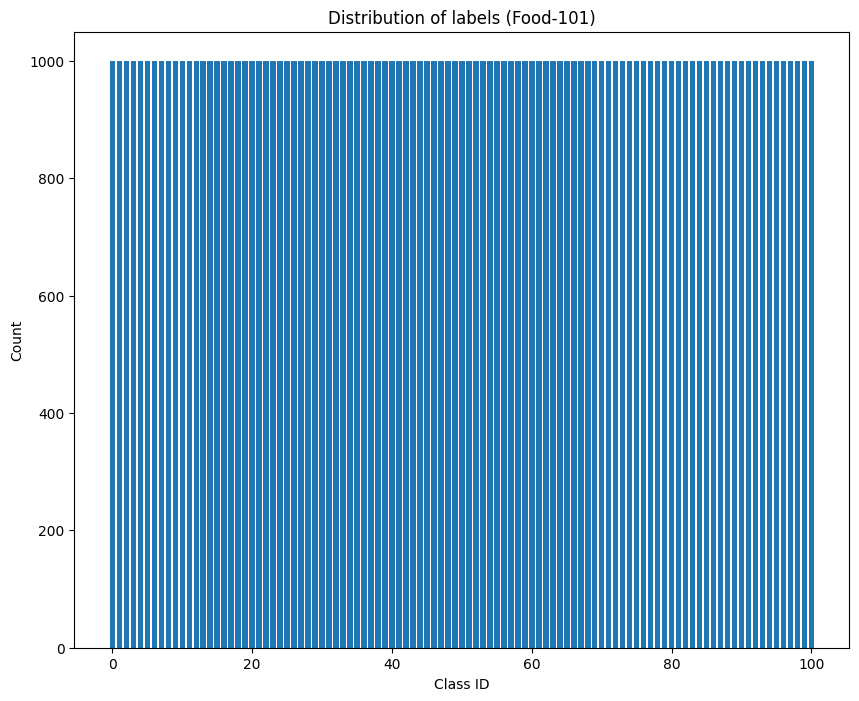

In [ ]:
label_counts = Counter(food_all["label"])

plt.figure(figsize=(10,8))
plt.bar(label_counts.keys(), label_counts.values())
plt.title("Distribution of labels (Food-101)")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()

In [ ]:
label_counts_tab = pd.DataFrame(label_counts.items(), columns=["label_id", "count"])
display(label_counts_tab.head())

label_id  count
0         6   1000
1        79   1000
2        81   1000
3        53   1000
4        10   1000

In [ ]:
bad_images = []

for i, ex in enumerate(food_all):
    try:
        ex["image"].verify()    # raise error if the image is unreadable
    except (IOError, UnidentifiedImageError):
        bad_images.append(i)

# Check for duplicates
hashes = [imagehash.average_hash(ex["image"]) for ex in food_all]
duplicates = [h for h, c in Counter(hashes).items() if c > 1]

print("Unreadable images:", len(bad_images))
print("Duplicate hash groups:", len(duplicates))

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Unreadable images: 0
Duplicate hash groups: 186


In [ ]:
print(food_label_names[:20])

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla']


Classes: 101
Total images: 101000
Min/Median/Max per class: 1000 1000.0 1000


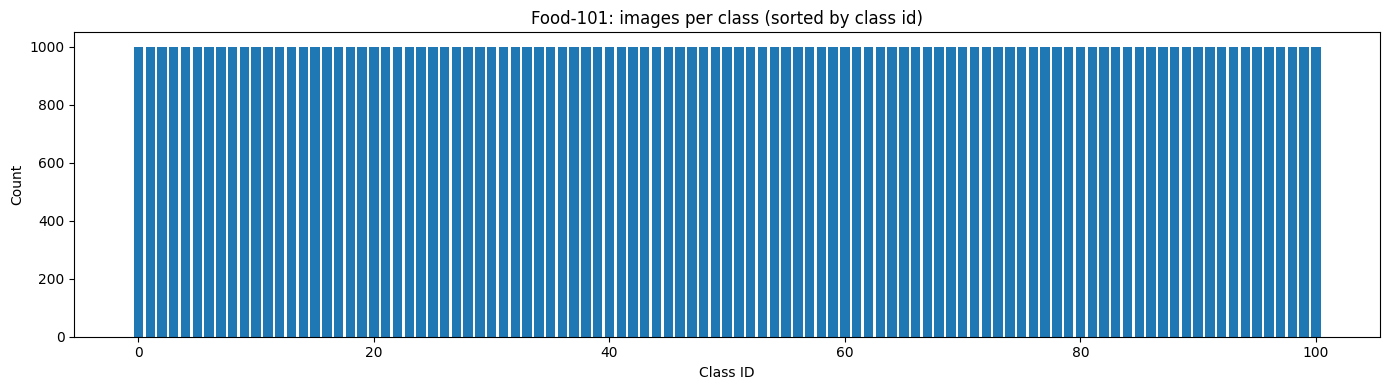

In [ ]:
from collections import Counter

# Label
labels_list = list(food_all[label_col])
counts = Counter(labels_list)

print("Classes:", len(food_label_names))
print("Total images:", len(labels_list))
print("Min/Median/Max per class:",
      min(counts.values()),
      np.median(list(counts.values())),
      max(counts.values()))

# Sorted bar plot
plt.figure(figsize=(14,4))
plt.bar(range(len(food_label_names)),
        [counts[i] for i in range(len(food_label_names))])
plt.title("Food-101: images per class (sorted by class id)")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


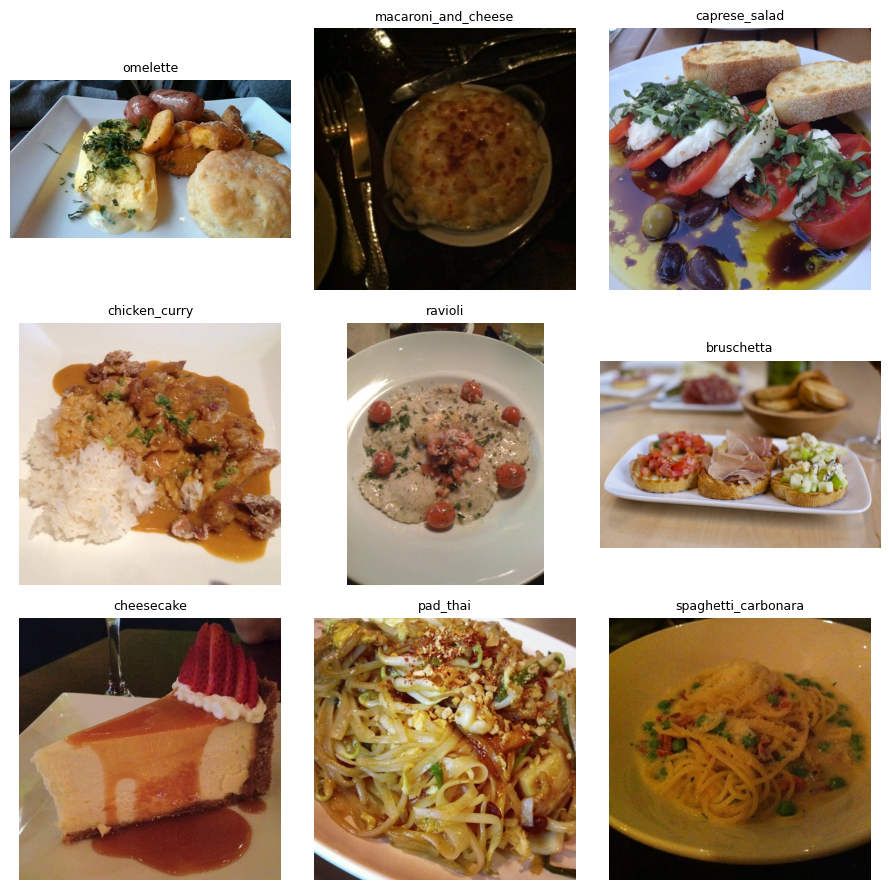

In [ ]:
import math, random
import matplotlib.pyplot as plt

n, cols, seed = 9, 3, 11
idxs = random.Random(seed).sample(range(len(food_all)), n)
rows = math.ceil(n / cols)

plt.figure(figsize=(3 * cols, 3 * rows))
for i, idx in enumerate(idxs, 1):
    ex = food_all[idx]
    plt.subplot(rows, cols, i)
    plt.imshow(ex["image"]); plt.axis("off")
    plt.title(food_label_names[ex[label_col]], fontsize=9)
plt.tight_layout(); plt.show()


### Graded Questions (2 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible.

1. **Dataset Summary:**  
   Describe your chosen dataset  (as if explaining to your *clueless boss* what you are working on).
   - State which dataset you are going to use.   
   - What kind of data does it contain (images or text)?  
   - How many samples and classes are there?  
   - What is the task you’ll perform (classification into what categories)?
   - What is the potential business use for this dataset?

1.1. **Your answer here:**

We will be using the Food 101 dataset. This dataset contains 101,000 images of food items all categorized into one of 101 classes that labels the food items. We will be performing a classification task that categorizes images into their respective classes. One potential business use for this dataset is for a calorie-counting app that allows users to take photos of their meal which recognizes each food item and helps users count the calories of their meal.

2. **Initial Observations:**  
   What stood out to you from your EDA?  
   - Did you notice any imbalanced or ambiguous classes?  
   - Any patterns, anomalies, or potential sources of bias?  
   - For images: note any variation in lighting, composition, or color.  
   - For text: mention redundancy, topic overlap, or very short examples.

1.2. **Your answer here:**

In the Food-101 dataset, the classes are balanced well and each class contains 1000 images. The classes are also clear to understand, but there are some that are similar to each other. Examples include caesar_salad/caprese_salad, apple_pie/cheesecake, and carrot_cake/baklava (desserts).

As the classes are very well balanced, there seems to be limited potential for bias. However, some bias may arise in the form of color, lighting, and focus of certain images. There are no anomalies.

There are a variety of images in the dataset, ranging from desserts to salads to meat dishes. Some images are darker than others while some are overexposed to light, creating variety in the dataset. Similarly, some images are of sharper quality while other are more blurry and unfocused. Color is also important to consider as some images have a brighter color/saturation and fall into a stronger RGB spectrum.

3. **Challenges & Implications:**  
   Based on your inspection, what challenges might affect model performance or training (e.g., imbalance, ambiguous labels, variable quality)?  

1.3. **Your answer here:**



In the Food-101 dataset, the main challenges stem from the variability in image quality rather than from the labels themselves. While the classes are balanced and clearly defined, differences in lighting, focus, color saturation, and composition across images can hinder model generalization. Additionally, visually similar food types (e.g., cheesecake vs. apple_pie) may increase classification confusion. These factors could make it harder for the model to learn consistent visual patterns and may require data augmentation or normalization to improve robustness.

4. **Preparation Ideas:**  
   What data-cleaning or preprocessing steps might help address these issues?  
   (You will not implement these yet—just describe what you might do later.)

1.4. **Your answer here:**

To address the issue we noticed, we plan to standardize the images so they are all the same size and normalized to reduce lighting differences. Since the dataset is scrapped from the internet, we also expect to run a quick duplicate check to make sure the same image doest appear in both training and validation splits. once modeling bgins we will apply data augmentation techniques like rotations, flips and slight color adjustments to help the model handle the natural variation in how these foods are photographed.

5. **Reflection:**  
   Why did you choose this dataset over the other one?  
   - What makes it more interesting, realistic, or relevant for you?  
   - What do you expect to learn from working with it?

1.5. **Your answer here:**

We chose the food 101 image dataset over the the Huffpost datsdet because image recognition feels way more relevant and exciting for us. Computer vision is used every where today, from phones that identify objects or translate signs, to apps that recognize products or food items instantly. Working with the image dataset lets us explore a realistic scenario where a model has to understand what it sees in a photo.

We expect to learn a lot about image processing, transfer learning and data augementation, and how to deal with visual challenges like lighting changes or look alike objects. Overall, this dataset gives us a chance to build a practical and modern AI system that reflects how technology is involved in the real world.

## Problem 2 – Frame the Problem (15 pts)

#### Objective

Identify the **key challenges** in your chosen dataset and outline **practical solutions** you would try, plus how you’ll **evaluate** them later.

#### Steps to follow

1. **Diagnose likely challenges (from your EDA):**

   Examples:
   * **Class imbalance:**
     Report label counts and an imbalance ratio (max / median). List any minority classes.
   * **Length/size variance:**
     For text, show length percentiles (50/75/90/95) and estimate truncation rate at candidate `max_text_length`s (e.g., 256/300/512). For images, summarize native resolutions.
   * **Noise/duplicates/leakage:**
     Note empty or malformed items, near-duplicates, and how you would prevent cross-split leakage.
   * **Ambiguous/overlapping labels:**
     Give 2–3 example pairs you expect to be confusable and why.
   * **Compute constraints:**
     Briefly state limits (RAM/GPU/CPU) that might affect batch size, sequence length, or image size.

2. **Map each challenge to a concrete solution plan:**

   Examples:
   * **Imbalance →** `class_weight` or oversampling; report which one you’d try first and why.
   * **Length/size →** pick a target `max_text_length` (e.g., 95th percentile) with masking; for images, standardize resize/crop and basic augmentation.
   * **Noise/duplicates →** dedupe (hash/near-dup), drop empty/very short items, document any relabeling.
   * **Ambiguity →** consider merging labels (if justified), or add features (bigrams/char-ngrams; simple image augmentations).
   * **Overfitting risk →** early stopping on your primary metric, dropout/weight decay, freeze-then-finetune plan (for pretrained features).

3. **Explore appropriate evaluation metrics:**

   Examples:
   * **Primary metric:** pick one aligned to your data (e.g., **macro-F1** if imbalanced; accuracy if balanced).
   * **Secondary metric(s):** per-class precision/recall, confusion matrix.
   * **Protocol:** stratified Train/Val/Test (e.g., 70/15/15), fixed seed, leakage checks.

4. **Answer the graded questions below.**



**Class Imbalance**

When reviewing the Food-101 dataset, our team found that it’s already quite balanced. Each of the 101 food categories includes around 800 training images, 100 validation images, and 100 test images. That gives an imbalance ratio close to 1.0, meaning that no single category dominates. Even though the numbers are even, some foods are visually more complex than others. For example, a dish like ramen can vary a lot depending on ingredients or lighting, while something simple like donuts tends to look more uniform. Because of this, we plan to keep an eye on per-class recall and accuracy to make sure the model isn’t favoring certain categories or struggling with others.

**Image Size Variance**

Another challenge we identified is the inconsistency in image sizes. Since Food-101 was collected from the internet, each image has different dimensions and aspect ratios, usually ranging from about 400 to 600 pixels. These differences can cause problems when batching data for training. To make the input consistent, we’ll resize all images to 224 by 224 pixels using a center crop. We’ll also normalize the RGB color channels so that lighting and brightness variations don’t confuse the model. After preprocessing, we’ll verify that all images are correctly formatted and that resizing helps stabilize training.

**Noise, Duplicates, and Leakage**

Because Food-101 is web-scraped, it’s likely that there are duplicate or near-duplicate images in the dataset. For example, the same photo of a pizza might appear multiple times, cropped or resized slightly differently. If duplicates exist in both the training and validation sets, it could artificially inflate the model’s accuracy. To prevent this, we’ll run a hash-based duplicate check to remove repeated images and ensure that each split training, validation, and test contains unique examples. We’ll also remove any unreadable or corrupted images we find. Once cleaning is complete, we’ll compare results before and after to confirm that no data leakage remains.

**Ambiguous or Overlapping Labels**

Some classes in Food-101 are visually very similar, which can easily confuse a model. Examples include apple pie and cheesecake, which both have golden crusts and creamy centers, or spaghetti bolognese and lasagna, which share similar textures and colors. In these cases, even a well-trained model might struggle to tell them apart. To handle this, we’ll evaluate model performance using both top-1 and top-5 accuracy, which allows for some flexibility when dishes look almost identical. We’ll also review the confusion matrix to identify which categories the model mixes up the most and consider applying targeted augmentations if certain pairs are consistently confused.

**Compute Constraints**




### Graded Questions (3 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible.

1. **State the prediction task**  
   - Describe what your model will predict (the *label*).  
   - *Examples:*  
     - “Given a photo of food, predict which of 101 categories it belongs to.”  
     - “Given a news headline + summary, predict its topical category.”  

2.1. **Your answer here:**

Given an image, our model will attempt to predict which of the 101 food categories it belongs to.

2. **Define inputs and outputs**  
   - *Inputs:* what information the model receives (e.g., pixel data, tokenized text).  
   - *Outputs:* the categorical label the model will predict.  

2.2. **Your answer here:**

The model will receive a single RGB image of a food item with certain characteristics, such as dimensions and pixels, and will output the predicted name of the food item.

3. **Identify possible challenges**  
   - Imbalanced classes, noisy data, ambiguous labels, overlapping features, or missing data  
   - *Images:* variation in lighting, color, composition, or size.  
   - *Text:* class imbalance, duplicate stories, short or ambiguous headlines.  

2.3. **Your answer here:**



The Food-101 dataset is largely neatly structured and well-balanced, with there being 1,000 images in each class. However, there are also other factors to consider:

First, image variability poses a key challenge. The images vary in lighting, color saturation, focus, and composition, since they were likely scraped from multiple web sources. These differing features can make it harder for a model to generalize by preventing accurate feature extraction/analysis.

Second, as mentioned previously, ambiguous/overlapping labels may lead to confusion between visually similar foods like apple_pie/cheesecake or caesar_salad/caprese_salad, which can reduce accuracy.

Third, the dataset may include duplicates or near-duplicates, which can inflate validation scores if similar images appear across splits.

Lastly, image size inconsistency requires standardization to avoid training instability.

No major missing or unreadable images were detected.

4. **Propose how you will prepare or improve the data to address the challenges**  
   - *Images:* resizing, normalization, data augmentation (flips, rotations, brightness, color jitter).  
   - *Text:* tokenization, stop-word removal, TF-IDF, class balancing, embeddings (choose an embedding approach and specify its vector size).

2.4. **Your answer here:**



To prepare the Food-101 dataset and address its challenges, the team will apply preprocessing techniques to improve standardization and generalization.

All images will be resized to a uniform pixel size to standardize input dimensions. RGB normalization will be applied using the mean and standard deviation of ImageNet to correct for lighting and color imbalance.

To increase model robustness, data augmentation techniques (random horizontal flips, random rotations, random crops/resizes, and brightness/contrast/color jitter) will be applied. These allow the model to learn invariance to differences in lighting, orientation, and background clutter.

We will also perform duplicate detection and removal using perceptual hashing to ensure no data leakage across train, validation, or test splits. Additionally, Any unreadable or malformed images will be excluded.

Together, these steps will make the dataset more uniform, reduce overfitting, and help the model generalize effectively to new, unseen food images.

5. **Specify success metrics**  
   - Identify the metrics you plan to use to evaluate model performance—typically **accuracy** and/or **F1-score**, which are standard for classification tasks.  
   - Briefly explain **why** these metrics are appropriate for your dataset and goal. For instance, accuracy may suffice for well-balanced datasets, while F1-score better reflects performance when some classes are under-represented.
   - If your dataset is **imbalanced**, consider computing **per-class metrics** (e.g., precision, recall, or F1 for each label) or **macro-averaged** scores, which give equal weight to each class regardless of its size—ensuring that minority classes are evaluated fairly.
In some cases, weighted averages (which weight classes by their frequency) or **confusion matrices** can also provide useful insight.
> You haven't run any models yet, and we haven’t studied every possible metric, but you’re encouraged to ask your favorite generative AI tool which evaluation metrics might best fit your dataset!
   - Clearly state how you will interpret success—for example, “Our goal is to achieve at least 80% overall accuracy without large per-class disparities.”

2.5. **Your answer here:**

We plan on using accuracy to evaluate our model's performance. This was determined after we found out that the dataset classes are well balanced, with each class containing 1000 images. Since accuracy is most suitable for well-balanced datasets, it would be the ideal success metric to evaluate our dataset. For per-class metrics, we will be using macro-averaged F1-score, which balances precision/recall and good for comparing models holistically. For specific classes that the model may struggle with differentiating, such as cheesecake vs apple_pie, looking at the confusion matrix may provide better insights. Overall, our goal is to achieve around 80-90% overall accuracy with 85-90% macro-F1 score for the per-class metrics.


### Final Question: Describe what use you made of generative AI tools in preparing this Milestone.

**AI Question: Your answer here:**

We used generative AI to give us some insights on various success metrics for multi-class classification tasks: https://grok.com/share/bGVnYWN5_4c524703-79b4-402b-a712-3cb76d3103f1.

---

## Appendix: A quick guide to Hugging Face Datasets

#### 1) What are they?

* A **table-like** dataset: rows = examples, columns = named fields (e.g., `"image"`, `"label"`, `"headline"`).
* Backed by **Apache Arrow** → fast, memory-efficient, lazy transforms.
* Two core objects:

  * `Dataset` — one table of rows/columns.
  * `DatasetDict` — a dict of splits, e.g. `{"train": Dataset, "val": Dataset, "test": Dataset}`.


#### 2) Load and inspect

```python
from datasets import load_dataset

# Food-101 (images)
food = load_dataset("food101", split="train+validation")  # both splits at once
len(food), food.column_names, food.features
# -> (≈101000, ['image','label'], {'label': ClassLabel(num_classes=101, names=[...])})

# Access by name (not by numeric column index!)
row0 = food[0]
img0, y0 = row0["image"], row0["label"]     # PIL image, int id
label_names = food.features["label"].names
label_names[y0]
```

For text (HuffPost JSON mirror):

```python
url = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff = load_dataset("json", data_files=url, split="train")
huff.column_names  # e.g. ['headline','short_description','category','authors','link','date']
```


#### 3) Common transforms

`Dataset`s are **immutable**: ops return a new dataset.

* **Map** (add/modify columns):

```python
def mk_text(ex):
    h = (ex.get("headline") or "").strip()
    s = (ex.get("short_description") or "").strip()
    return {"text": (h + " [SEP] " + s).strip()}

huff = huff.map(mk_text)  # adds 'text' column
```

* **Class-encode** labels (strings → integers with a vocabulary):

```python
from datasets.features import ClassLabel
if not isinstance(huff.features["category"], ClassLabel):
    huff = huff.class_encode_column("category")  # now ints with .names
```

* **Filter / select / rename / drop**:

```python
small = huff.select(range(5000))  # first 5k rows
huff = huff.remove_columns(["authors","link","date"])
huff = huff.rename_column("category", "label")
```


#### 4) Splitting & shuffling

```python
# Stratified 80/10/10 on Food-101 by 'label'
from datasets import DatasetDict
label_col = "label"

tmp = food.train_test_split(test_size=0.10, seed=42, stratify_by_column=label_col)
train_val = tmp["train"].train_test_split(test_size=1/9, seed=42, stratify_by_column=label_col)
ds = DatasetDict(train=train_val["train"], val=train_val["test"], test=tmp["test"])

len(ds["train"]), len(ds["val"]), len(ds["test"])
```

* `train_test_split` is **random by default** (reproducible with `seed=`).
* You typically **don’t need to pre-shuffle** datasets if your training dataloader already shuffles each epoch.


#### 5) Working with images

Use `with_transform` to apply on-the-fly resizing/augmentation and return tensors:

```python
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch, math, random

IM_SIZE = 224
train_tfms = T.Compose([T.RandomResizedCrop(IM_SIZE), T.RandomHorizontalFlip(), T.ToTensor()])
eval_tfms  = T.Compose([T.Resize(256), T.CenterCrop(IM_SIZE), T.ToTensor()])

def add_pixel_values(ex, tfms):  # ex['image'] -> ex['pixel_values']
    ex = dict(ex); ex["pixel_values"] = tfms(ex["image"]); return ex

train_t = ds["train"].with_transform(lambda ex: add_pixel_values(ex, train_tfms))
val_t   = ds["val"].with_transform(lambda ex: add_pixel_values(ex, eval_tfms))

def collate(batch):
    return {"pixel_values": torch.stack([b["pixel_values"] for b in batch]),
            "labels": torch.tensor([b["label"] for b in batch])}

train_loader = DataLoader(train_t, batch_size=64, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(val_t,   batch_size=64, shuffle=False, collate_fn=collate)
```

### 6) Working with Text

You can preprocess and tokenize text datasets using either a **transformer tokenizer** or a **linguistic pipeline like spaCy**, depending on your model type and goals.


#### Option A: Transformer Tokenizer (for fine-tuning models like BERT or DistilBERT)

Use a pretrained tokenizer with the Hugging Face `map` method to efficiently process your dataset in batches:

```python
from transformers import AutoTokenizer

tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=128)

tokenized = huff.map(
    tokenize,
    batched=True,
    remove_columns=[c for c in huff.column_names if c not in ("category", "label")]
)
```

This produces token IDs, attention masks, and other fields expected by transformer models.
Use this approach if your project involves fine-tuning pretrained language models.


#### Option B: spaCy Tokenization and Cleaning (for classical ML or custom preprocessing)

If you are **not using transformers**, or if you want to explore feature engineering (e.g., TF-IDF, word frequency, or embedding averages), you can preprocess text with **spaCy** instead.

```python
# !pip install spacy
# !python -m spacy download en_core_web_sm

import spacy
from datasets import load_dataset

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])
STOP = spacy.lang.en.stop_words.STOP_WORDS

def spacy_clean(batch):
    docs = list(nlp.pipe(batch["text"], batch_size=1000))
    cleaned = []
    for doc in docs:
        tokens = [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop]
        cleaned.append(" ".join(tokens))
    return {"text_clean": cleaned, "len_tokens": [len(c.split()) for c in cleaned]}

huff = huff.map(
    spacy_clean,
    batched=True,
    batch_size=1000,
    remove_columns=[c for c in huff.column_names if c not in ("category", "label")]
)
```

The resulting column `text_clean` can be used with:

* `TfidfVectorizer` (Scikit-learn)
* `TextVectorization` (Keras)
* or any other custom embedding method.

> 💡 **Tip:** spaCy is ideal for lightweight NLP pipelines or for models that rely on explicit preprocessing (lemmatization, stopword removal). Transformer tokenizers, by contrast, expect *raw text* and handle subword tokenization internally.



#### 7) Slicing, concatenating, saving

```python
# Slicing
head_1000 = food.select(range(1000))
tail_10pct = food.select(range(int(0.9*len(food)), len(food)))

# Concatenate splits/datasets
from datasets import concatenate_datasets
all_train = concatenate_datasets([ds["train"], ds["val"]])

# Save / reload
ds.save_to_disk("food101_splits")
from datasets import load_from_disk
ds2 = load_from_disk("food101_splits")
```


#### 8) Quick “gotchas”

* **Columns by name** (strings), not numeric indices.
* Avoid converting huge columns to `list(...)` unless necessary; prefer vectorized ops with `map`, `filter`, `select`.
* `PYTHONHASHSEED` must be set **before** the Python process starts to matter; use explicit `seed=` arguments for reproducibility.
* Datasets print **previews** (e.g., `Column([6, 6, 6, ...])` is just the first few values).


#### 9) A minimal checklist to follow

1. `load_dataset(...)` → confirm `column_names`, `features`.
2. Build any needed columns (`"text"`), and **class-encode** labels if strings.
3. Make a **stratified 80/10/10** split (`train_test_split` ×2).
4. Do **EDA**: class counts, sample printouts or image grids.
5. For training:

   * **images** → `with_transform` + DataLoader
   * **text** → tokenizer via `.map(...)` + trainer/model pipeline
6. Save your `DatasetDict` with `save_to_disk(...)` (optional for text but handy, **don't** use it for big image datasets).

